In [2]:
# Import multiple essential libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from wordcloud import WordCloud
from wordcloud import STOPWORDS

# ignore the warning message
import warnings
warnings.filterwarnings('ignore')



In [3]:
# Data Insights:
# Few problems to be solved:
# 1. We wish to understand why 'good' employee wish to leave.
# 2. Predict who is likely to leave

In [4]:
# Kaggle HR Analytics 
# URL: https://www.kaggle.com/datasets/vjchoudhary7/hr-analytics-case-study

In [5]:
# Access files with relative path
path = 'dataset/'
employee = pd.read_csv(path + 'employee_survey_data.csv')
general = pd.read_csv(path + 'general_data.csv')
in_time = pd.read_csv(path + 'in_time.csv')
manager_survey = pd.read_csv(path + 'manager_survey_data.csv')
out_time = pd.read_csv(path + 'out_time.csv')


### Data Understanding

In [6]:
# Acquire basic information about each dataset
def missing_columns(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values.sort_values(ascending = False)
    
    return missing_values

def df_info_(df):
    """
        Information about the DataFrame
        # Columns Data Type
        # Data Frame shape
        # Columns Name
        # Columns Description
    """
    features_dtypes = df.dtypes
    rows,columns = df.shape

    missing_col = missing_columns(df)
    features_names = missing_col.index.values
    missing_values = missing_col.values

    print('=' * 50)
    print('===> This data frame contains {} rows and {} columns'.format(rows,columns))
    print('=' * 50)

    print("{:13}{:13}{:30}{:15}".format('Feature Name'.upper(),
                                        'Data Format'.upper(),
                                        'Number of Missing Values'.upper(),
                                        'The first few samples'.upper()))

    for features_names, features_dtypes, missing_values in zip(features_names,features_dtypes[features_names],missing_values):
        print('{:15} {:14} {:20}'.format(features_names, str(features_dtypes), str(missing_values) + '-' +
                                         str(round(100*missing_values/sum(missing_col),3))+' %'), end=" ")

        for i in range(5):
            print(df[features_names].iloc[i], end=",")

        print("="*50)
        

In [7]:
df_info_(employee)

===> This data frame contains 4410 rows and 4 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
WorkLifeBalance float64        38-45.783 %          2.0,4.0,1.0,3.0,3.0,==================================================
EnvironmentSatisfaction float64        25-30.12 %           3.0,3.0,2.0,4.0,4.0,==================================================
JobSatisfaction float64        20-24.096 %          4.0,2.0,2.0,4.0,1.0,==================================================
EmployeeID      int64          0-0.0 %              1,2,3,4,5,==================================================


In [8]:
df_info_(general)

===> This data frame contains 4410 rows and 24 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
NumCompaniesWorked float64        19-67.857 %          1.0,0.0,1.0,3.0,4.0,==================================================
TotalWorkingYears float64        9-32.143 %           1.0,6.0,5.0,13.0,9.0,==================================================
Age             int64          0-0.0 %              51,31,32,38,32,==================================================
Attrition       object         0-0.0 %              No,Yes,No,No,No,==================================================
YearsSinceLastPromotion int64          0-0.0 %              0,1,0,7,0,==================================================
YearsAtCompany  int64          0-0.0 %              1,5,5,8,6,==================================================
TrainingTimesLastYear int64          0-0.0 %              6,3,2,5,2,==================================================
StockOptionLevel int64   

In [9]:
df_info_(manager_survey)

===> This data frame contains 4410 rows and 3 columns
FEATURE NAME DATA FORMAT  NUMBER OF MISSING VALUES      THE FIRST FEW SAMPLES
EmployeeID      int64          0-nan %              1,2,3,4,5,==================================================
JobInvolvement  int64          0-nan %              3,2,3,2,3,==================================================
PerformanceRating int64          0-nan %              3,4,3,3,3,==================================================


In [10]:
# Assume 1st column in Employee ID 
in_time.rename(columns = {"Unnamed: 0": "EmployeeID"}, inplace=True)

out_time.rename(columns = {'Unnamed: 0': 'EmployeeID'}, inplace=True)


In [11]:
# Double - Check
in_time.head()

,EmployeeID,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


### Data Visualisation

In [10]:
def words_popular(dataframe,col,heads):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color = 'white', 
                          stopwords = stopwords).generate(str(dataframe[col]))
    
    plt.rcParams['figure.figsize'] = (12, 8)
    print(wordcloud)
    plt.imshow(wordcloud)
    plt.title(heads, fontsize = 30)
    plt.axis('off')
    plt.show()
    

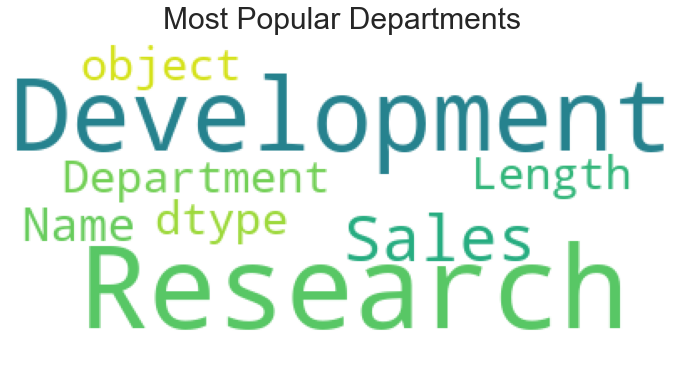

In [11]:
# Department Analysis
# Looking at the most popular departments
words_popular(general,'Department','Most Popular Departments')


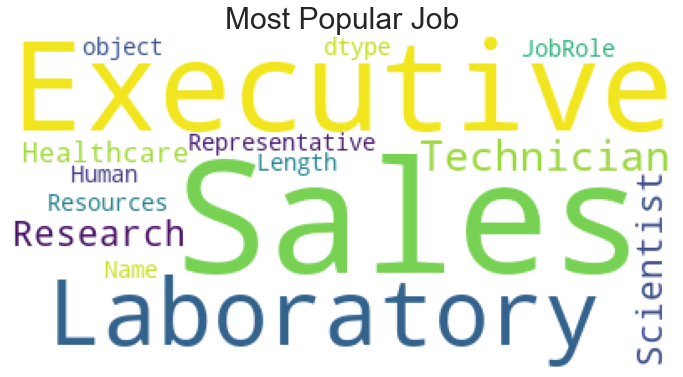

In [12]:
# Job Role Analysis
words_popular(general,'JobRole','Most Popular Job')


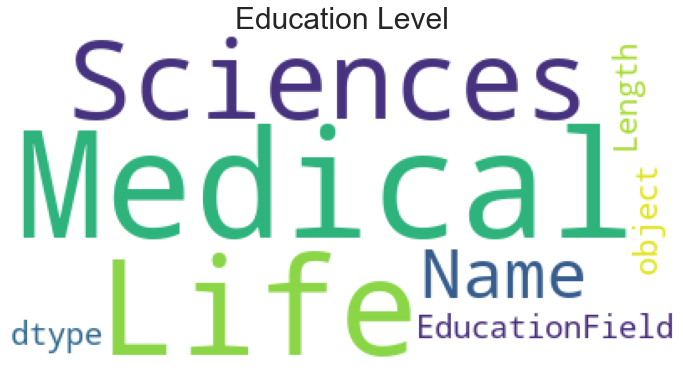

In [13]:
words_popular(general,'EducationField','Education Level')

### Employee Table Analysis

In [59]:
import plotly.express as px
# Bar chart (horizontal chart for WorkLifeBalance)
worklife_df = employee.groupby(['WorkLifeBalance'])['EmployeeID'].agg(['count']).reset_index()

fig = px.bar(worklife_df, x = 'count', y = 'WorkLifeBalance', orientation = 'h')
fig.show()

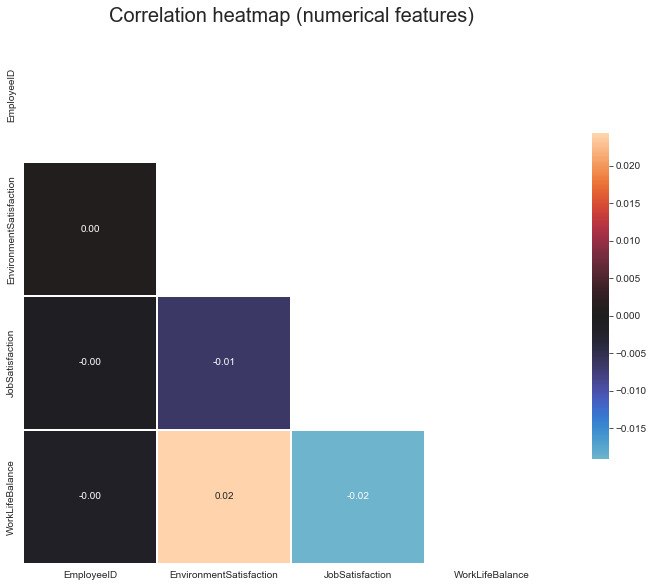

In [13]:
# Generate a heat map to check its attribute numerical correlation in employee table
f,ax = plt.subplots(figsize=(12, 12))
corr = employee.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, linewidths=.1, fmt= '.2f',ax=ax,
            center=0, square=True, cbar_kws={'shrink': .5}
            )
plt.title('Correlation heatmap (numerical features)', size=20)
plt.show();

### General Table Analysis

In [17]:
general['Temp'] = 1

In [18]:
def pie_chart(dataframe, col,target,color,title):
    plt.figure(figsize=(10,5), dpi = 100)
    target_df = dataframe.groupby([col])[target].agg(['count']).reset_index()

    plt.pie(target_df['count'],labels = target_df[col],
            autopct='%1.2f%%', startangle=45, colors=sns.color_palette(color),
            labeldistance=0.75, pctdistance=0.4)
    plt.title(title, fontsize = 20)
    plt.axis('off')
    plt.legend()
    plt.show()
    

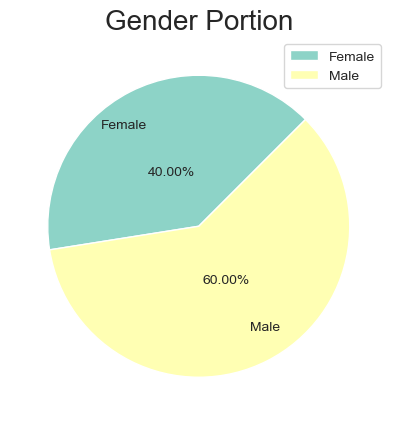

In [19]:
pie_chart(general, 'Gender','EmployeeID','Set3','Gender Portion')

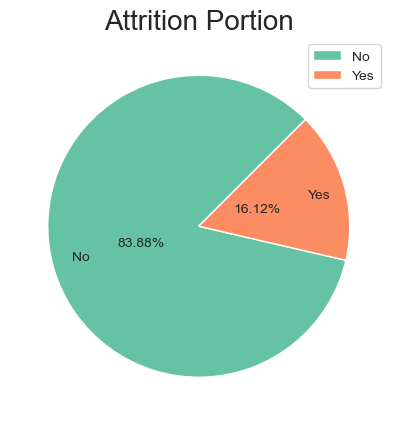

In [20]:
pie_chart(general, 'Attrition','Attrition','Set2','Attrition Portion')


In [24]:
general.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Temp'],
      dtype='object')

<AxesSubplot:xlabel='BusinessTravel', ylabel='Temp'>

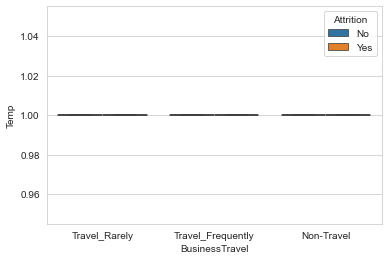

In [25]:
# To look into the age by Attrition
sns.boxplot( x = 'BusinessTravel', y = 'Temp', hue = 'Attrition', data = general)


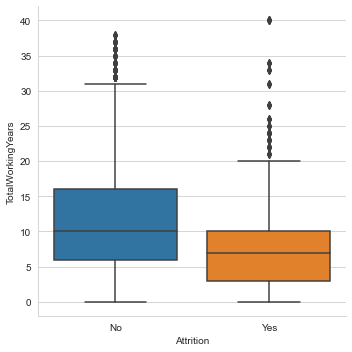

In [21]:
# To dive into the distribution of working year by Attrition
sns.factorplot(data=general,y='TotalWorkingYears',x='Attrition',size=5,aspect=1,kind='box')


Conclusion: TotalWorkingYear 

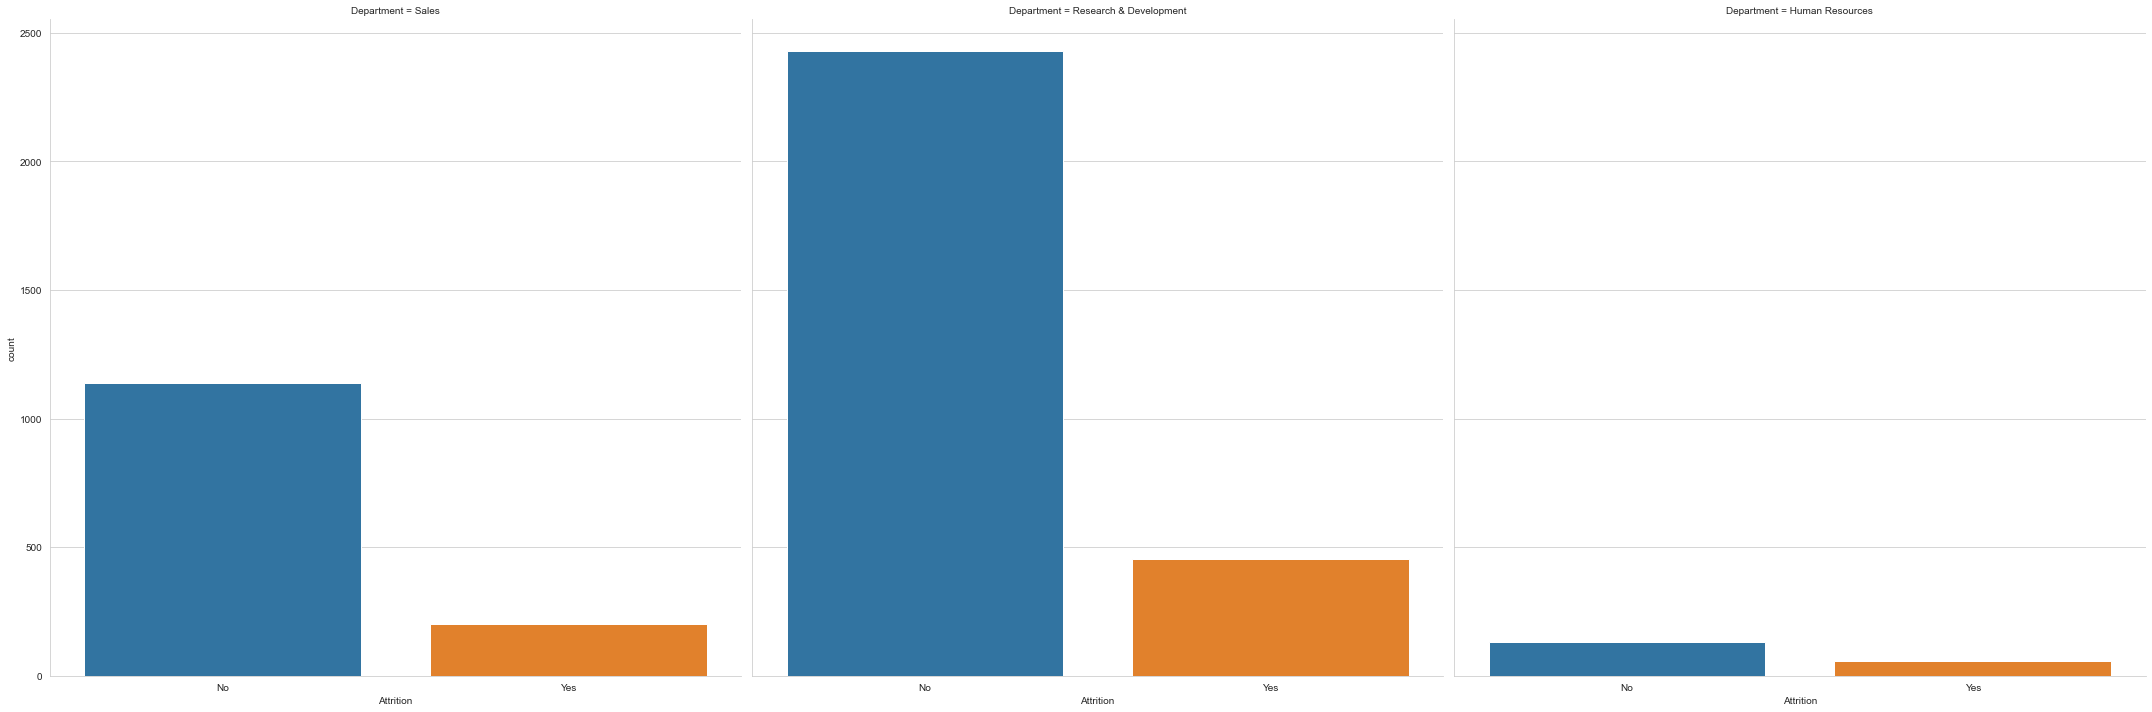

In [22]:
# Attrition by Department
sns.factorplot(data=general,kind='count',x='Attrition',col='Department',size=10,aspect=1)
plt.show()


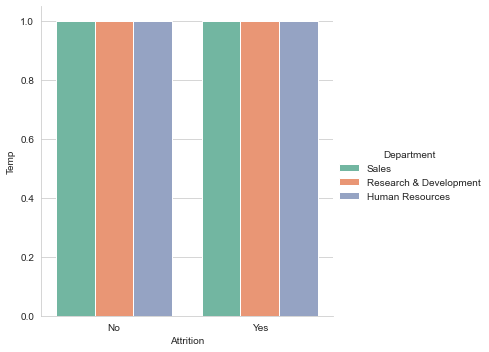

In [23]:
# Example 5: Bar plot with processed data
sns.catplot(x='Attrition', y='Temp', hue='Department', data=general, kind='bar', size = 5, palette='Set2')
plt.show()

In [66]:
fig = px.bar(general, x = 'EmployeeID', y = 'Attrition', color = 'Department', orientation = 'h',
             height = 400,
             title = 'Attition by Department')
fig.show()

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Bar(
    y = [],
    x = [],
    name = 'Stock 1',
    orientation = 'h',
    marker = dict(
        color ='rgba(',
        line = dict(color = 'rgba(246,78,139,1)', width = 3)
    )
))



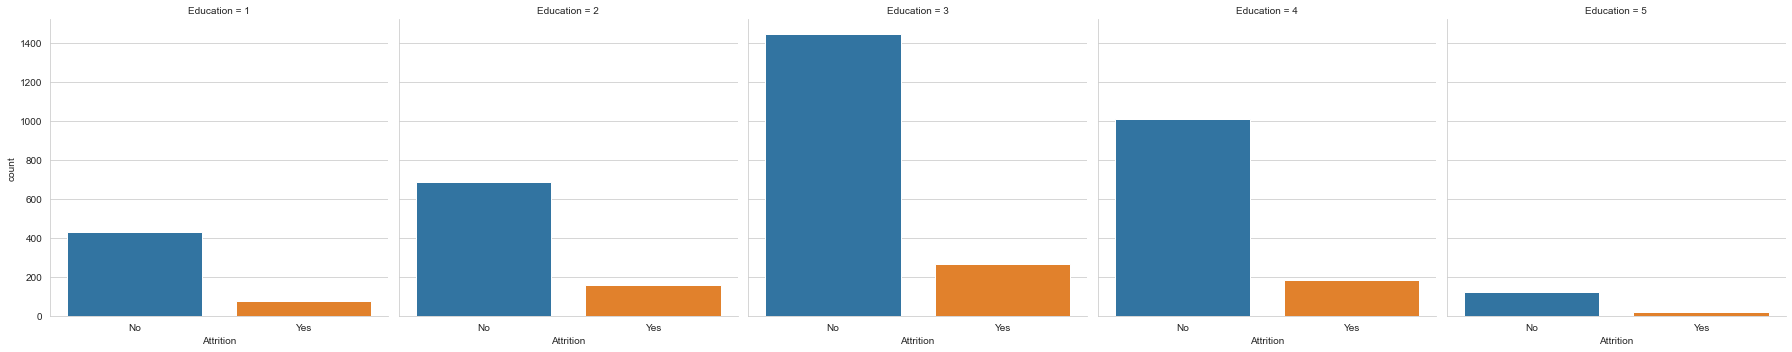

In [25]:
# Attrition by Education
sns.factorplot(data=general,kind='count',x='Attrition',col='Education')


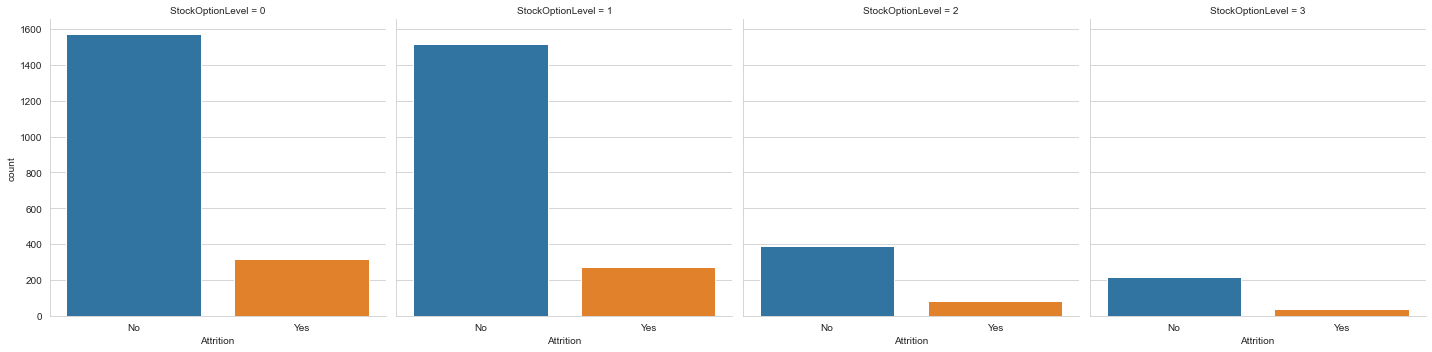

In [26]:
# Attrition by Stock Option
sns.factorplot(data=general,kind='count',x='Attrition',col='StockOptionLevel')


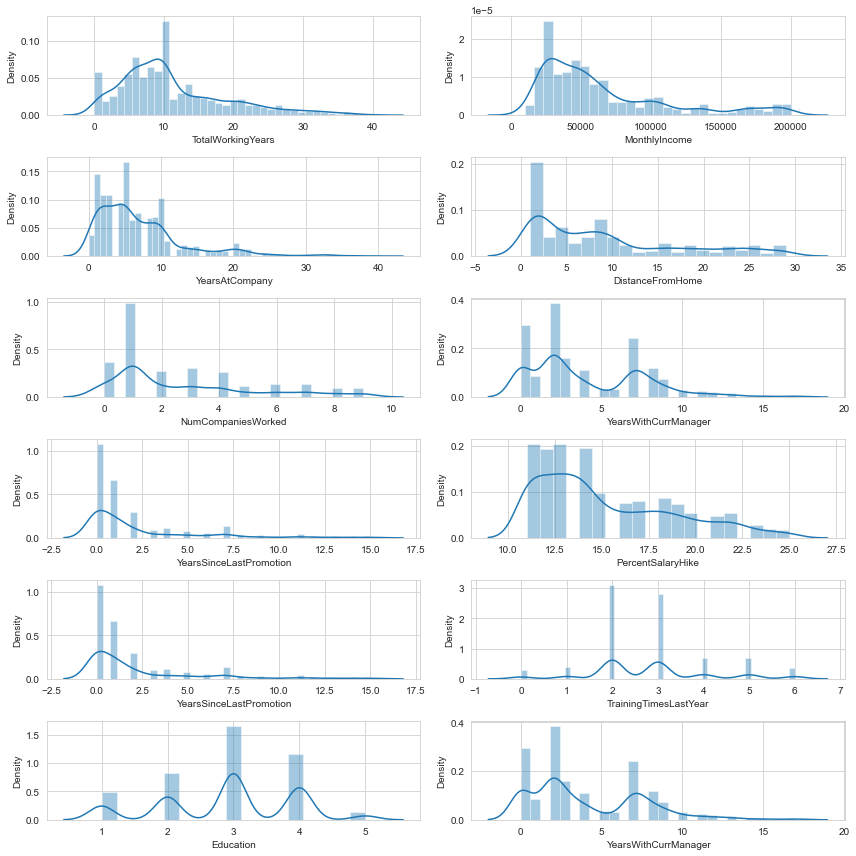

In [67]:
# Distribution of Numerical Values by Categories
fig,ax = plt.subplots(6,2, figsize=(12,12))
sns.distplot(general['TotalWorkingYears'], ax = ax[0,0])
sns.distplot(general['MonthlyIncome'], ax = ax[0,1])
sns.distplot(general['YearsAtCompany'], ax = ax[1,0])
sns.distplot(general['DistanceFromHome'], ax = ax[1,1])
sns.distplot(general['NumCompaniesWorked'], ax = ax[2,0])
sns.distplot(general['YearsWithCurrManager'], ax = ax[2,1])
sns.distplot(general['YearsSinceLastPromotion'], ax = ax[3,0])
sns.distplot(general['PercentSalaryHike'], ax = ax[3,1])
sns.distplot(general['YearsSinceLastPromotion'], ax = ax[4,0])
sns.distplot(general['TrainingTimesLastYear'], ax = ax[4,1])
sns.distplot(general['Education'], ax = ax[5,0])
sns.distplot(general['YearsWithCurrManager'], ax = ax[5,1])
plt.tight_layout()
plt.show()


In [42]:
def distribution_plt(dataframe,column_name,title,xlabel,ylabel):
    # Distribution of Age of Employees
    sns.distplot(dataframe[column_name], color = 'red')
    plt.title(title, fontsize = 30)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel(ylabel)
    plt.axvline(np.median(dataframe[column_name]), 0, linestyle='--', linewidth=1.5, color='b')
    plt.show()

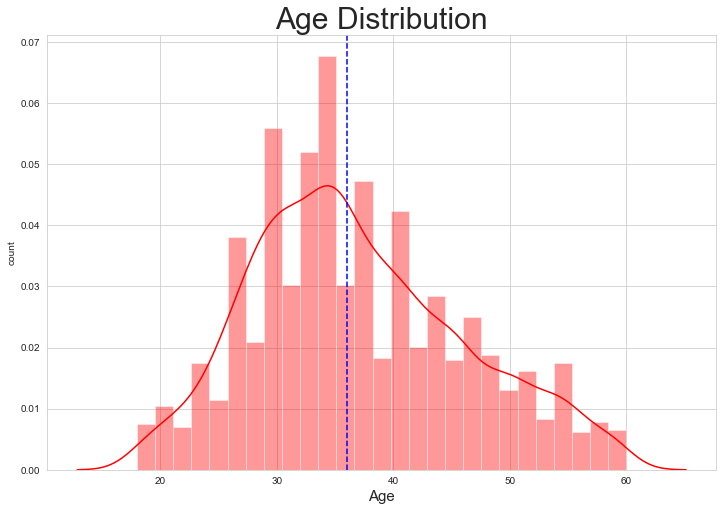

In [43]:
distribution_plt(general,'Age','Age Distribution','Age','count')

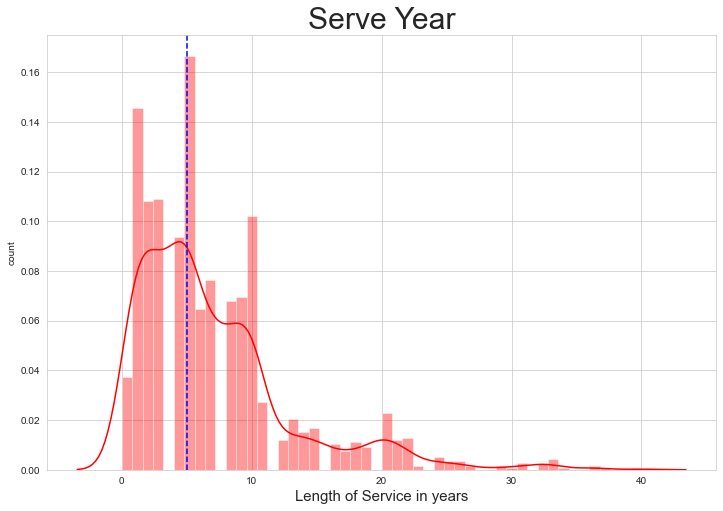

In [44]:
distribution_plt(general,'YearsAtCompany','Serve Year','Length of Service in years','count')


The Distribution of length of service is left-skewed. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


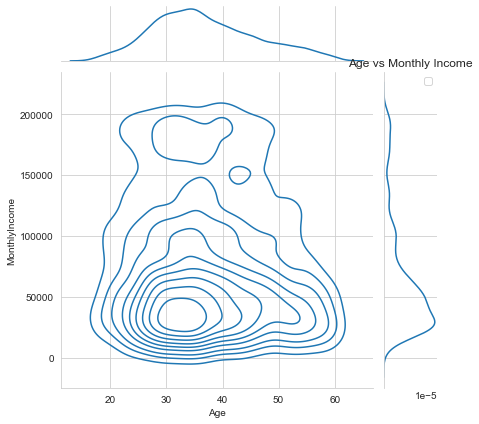

In [32]:
sns.jointplot(x="Age", y="MonthlyIncome", data=general, kind='kde')
plt.xlabel('Age')
plt.ylabel('MonthlyIncome')
plt.title('Age vs Monthly Income')

plt.legend()
plt.show()

In [35]:

# Generate a copy of employee, name it employee clean and remove its isnull rows
# Remove all isnull rows
employee_clean = employee.copy(deep = True)
employee_clean = employee_clean.merge(general, how = 'inner', on = 'EmployeeID')
employee_clean = employee_clean.merge(manager_survey, on = 'EmployeeID', how = 'inner')
employee_clean = employee_clean.dropna()

print(employee_clean.shape)
print('-'*50)
print(employee.shape)

(4300, 29)
--------------------------------------------------
(4410, 4)


In [36]:
employee_clean.columns

Index(['EmployeeID', 'EnvironmentSatisfaction', 'JobSatisfaction',
       'WorkLifeBalance', 'Age', 'Attrition', 'BusinessTravel', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'Gender', 'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating'],
      dtype='object')

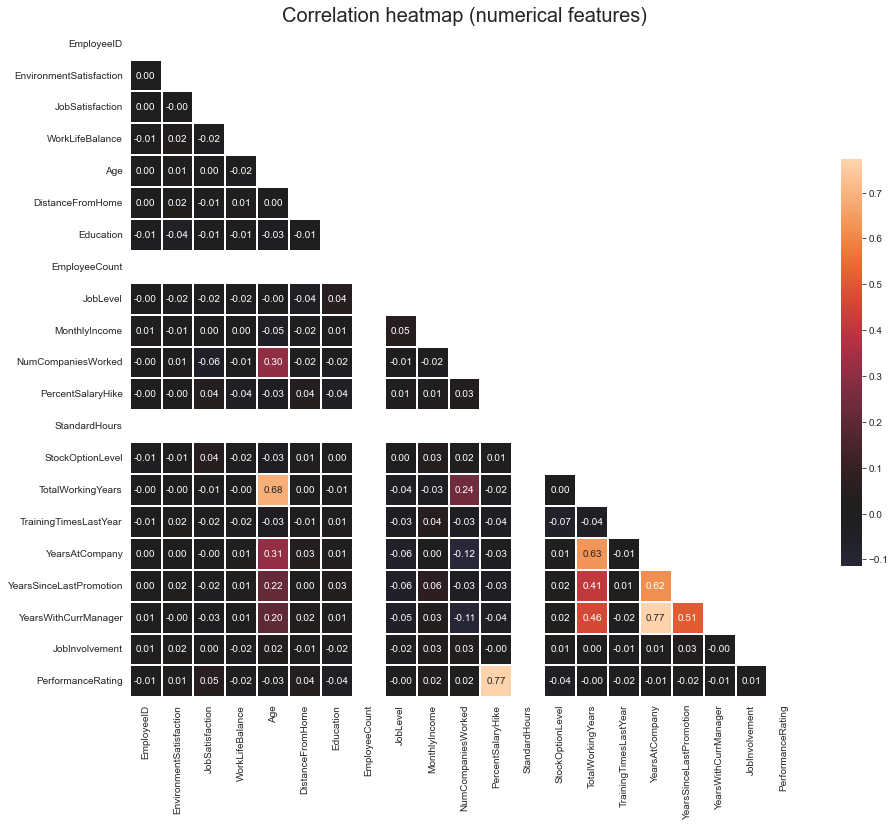

In [38]:
# Generate heatmap about employee table
f,ax = plt.subplots(figsize=(15, 15))
corr = employee_clean.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, annot=True, linewidths=.1, fmt= '.2f',ax=ax,
            center=0, square=True, cbar_kws={'shrink': .5}
            )
plt.title('Correlation heatmap (numerical features)', size=20)
plt.show();

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


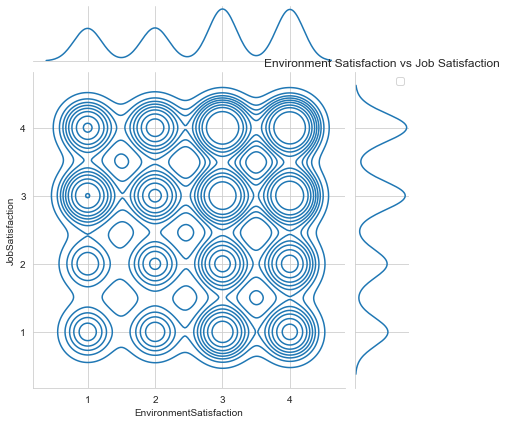

In [36]:
sns.jointplot(x="EnvironmentSatisfaction", y="JobSatisfaction", data=employee_clean, kind='kde')
plt.xlabel('Environment Satisfaction')
plt.ylabel('Job Satisfaction')
plt.title('Environment Satisfaction vs Job Satisfaction')

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


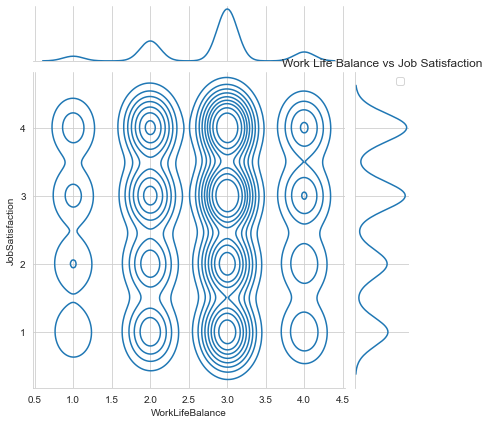

In [37]:
sns.jointplot(x="WorkLifeBalance", y="JobSatisfaction", data=employee_clean, kind='kde')
plt.xlabel('Work Life Balance')
plt.ylabel('Job Satisfaction')
plt.title('Work Life Balance vs Job Satisfaction')

plt.legend()
plt.show()

## Data Pre-processing

In [26]:
# Merge Multiple Data Tables
df = general.merge(employee, on = 'EmployeeID', how = 'inner')
df = df.merge(manager_survey, on = 'EmployeeID', how = 'inner')
#df = df.merge(in_time, on = 'EmployeeID', how = 'inner')
#df = df.merge(out_time, on = 'EmployeeID', how = 'inner')
df.head(10)

# Drop multiple cols 
df.drop(columns = ['Over18'],inplace = True)
print(df.shape)


(4410, 29)


In [27]:
duration = out_time - in_time


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [28]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'Temp', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating'],
      dtype='object')

In [36]:
df['WorkLifeBalance'].unique()

array([ 2.,  4.,  1.,  3., nan])

In [59]:
# Decoding Values
df['Education'] = df['Education'].replace({ 1 : 'Below College', 2: 'College',3: 'Bachelor',4: 'Master',5 : 'Doctor'})
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
df['JobInvolvement'] = df['JobInvolvement'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
df['JobSatisfaction'] = df['JobSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
# df['RelationshipSatisfaction'] = df['RelationshipSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
df['PerformanceRating'] = df['PerformanceRating'].replace({ 1 : 'Low', 2: 'Good',3: 'Excellent',4: 'Outstanding'})
df['WorkLifeBalance'] = df['WorkLifeBalance'].replace({ 1 : 'Bad', 2: 'Good',3: 'Better',4: 'Best'})

KeyError: 'RelationshipSatisfaction'

In [58]:
# Data Encoding
cols = ['Education','JobInvolvement','WorkLifeBalance','PerformanceRating','JobSatisfaction','EnvironmentSatisfaction']
for column in cols:
    



Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating'],
      dtype='object')

In [57]:
df.head(10)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3
5,46,No,Travel_Rarely,Research & Development,8,3,Life Sciences,1,6,Female,...,28.0,5,7,7,7,3.0,2.0,2.0,3,3
6,28,Yes,Travel_Rarely,Research & Development,11,2,Medical,1,7,Male,...,5.0,2,0,0,0,1.0,3.0,1.0,3,4
7,29,No,Travel_Rarely,Research & Development,18,3,Life Sciences,1,8,Male,...,10.0,2,0,0,0,1.0,2.0,3.0,3,4
8,31,No,Travel_Rarely,Research & Development,1,3,Life Sciences,1,9,Male,...,10.0,2,9,7,8,2.0,4.0,3.0,3,4
9,25,No,Non-Travel,Research & Development,7,4,Medical,1,10,Female,...,6.0,2,6,1,5,2.0,1.0,3.0,3,3


In [45]:
import xgboost as xgb
import numpy as np
import tensorflow as tf

# Generate some dummy data
n_samples = 100
n_features = 10
X_train = np.random.rand(n_samples, n_features)
y_train = np.random.randint(low=0, high=2, size=n_samples)

# Convert the data to TensorFlow format
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.batch(32)

# Create a TensorFlow iterator to consume the data
iterator = tf.compat.v1.data.make_initializable_iterator(train_data)
next_batch = iterator.get_next()

# Set up the XGBoost DMatrix
dtrain = xgb.DMatrix(next_batch[0], label=next_batch[1])

# Define the XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 1.0,
    'nthread': 4
}

# Train the XGBoost model
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Initialize the TensorFlow session
with tf.compat.v1.Session() as sess:
    # Initialize the iterator
    sess.run(iterator.initializer)

    # Fetch the next batch for evaluation
    X_eval_batch, y_eval_batch = sess.run(next_batch)

    # Convert the evaluation data to XGBoost DMatrix
    deval = xgb.DMatrix(X_eval_batch, label=y_eval_batch)

    # Make predictions using the trained model
    y_pred = xgb_model.predict(deval)
    print("Predictions:", y_pred)

2023-12-28 19:43:54.246274: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


RuntimeError: `make_initializable_iterator()` is not supported in eager mode. Use Python-style iteration instead.

Oversampling of the Model

In [ ]:

from imblearn.over_sampling import SMOTE

x_sample, y_sample = SMOTE().fit_sample(x, y.values.ravel())

x_sample = pd.DataFrame(x_sample)
y_sample = pd.DataFrame(y_sample)

# checking the sizes of the sample data
print("Size of x-sample :", x_sample.shape)
print("Size of y-sample :", y_sample.shape)

In [ ]:

# splitting x and y into train and validation sets

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_sample, y_sample, test_size = 0.2, random_state = 0)

print("Shape of x_train: ", x_train.shape)
print("Shape of x_valid: ", x_valid.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of y_valid: ", y_valid.shape)

In [ ]:
# standard scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_valid = sc.transform(x_valid)

Applying PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = None)
x_train = pca.fit_transform(general)
x_test = pca.transform(general)
x_valid = pca.transform(general)

Xgboost Algorithm

In [ ]:
# 
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import average_precision_score